#  Neural Style Transfer

In [1]:
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
# transfer learning with keras https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e
# import tensorflow as tf
import tensorflow.compat.v1 as tf   # this line is using so that can use precious version function so we need not to shift to previous versoin
tf.disable_v2_behavior()
# https://www.analyticsvidhya.com/blog/2020/10/introduction-and-implementation-to-neural-style-transfer-deep-learning/
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
class CONFIG:
    IMAGE_WIDTH = 712
    IMAGE_HEIGHT = 474
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    
    
def load_vgg_model(path):
    
    print(path)
    
#     https://in.mathworks.com/help/deeplearning/ref/vgg19.html
     
    """"
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    print(vgg.keys())  #dict_keys(['__header__', '__version__', '__globals__', 'layers', 'meta'])

    print(vgg['layers'].shape)    #(1, 43)
#     print(vgg.shape)   dict has no shape
    print(type(vgg))
#     print(vgg)
#     print(vgg['layers'])
    print(type(vgg['layers']))
    

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        
        wb = vgg_layers[0][layer][0][0][2]
        print(wb)
        print(vgg_layers[0][layer].shape)
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b


    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        print(W.shape,b.shape)
        
        return tf.nn.conv2d(prev_layer, filters=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.  only extracting the weight of conv layer other manully
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    
#     Now, we initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the
#     generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the
#     "generated" image more rapidly match the content of the "content" image.
    noise_image = np.random.uniform(-20, 20, (1,content_image.shape[1],content_image.shape[2],content_image.shape[3] )).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image


def reshape_and_normalize_image(image):
    
    image = np.reshape(image, ((1,) + image.shape))
    print(image.shape)
    image = image - CONFIG.MEANS
    
    return image


def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    plt.imsave(path, image)


We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 


(400, 300, 3)


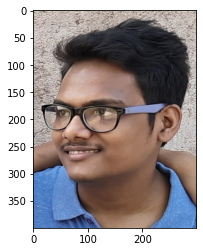

In [3]:
content_image = plt.imread("images/c_i.jpeg")
imshow(content_image)
print(content_image.shape)
CONFIG.IMAGE_WIDTH=content_image.shape[1]
CONFIG.IMAGE_HEIGHT=content_image.shape[0]
CONFIG.COLOR_CHANNELS=content_image.shape[2]

In [4]:

def compute_content_cost(a_C, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    print(a_C.shape)
    print(a_G.shape)
    a_C_unrolled = tf.reshape(a_C, shape = [m, n_H, n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape = [m, n_H, n_W, n_C])
    print(a_C.shape)
    print(a_G.shape)
    print(a_G_unrolled)
    print(a_C_unrolled)
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
    return J_content

In [5]:
tf.reset_default_graph()  #used in tensorflow 1.15  for testing so don't distrucb main graph
# tf.compat.v1.reset_default_graph

# tf.reset_default_graph() can be helpful (at least for me) during the testing phase while I 
# experiment in jupyter notebook. However, I have never used it in production and do not see how it would be helpful there.

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

(1, 4, 4, 3)
(1, 4, 4, 3)
(1, 4, 4, 3)
(1, 4, 4, 3)
Tensor("Reshape_1:0", shape=(1, 4, 4, 3), dtype=float32)
Tensor("Reshape:0", shape=(1, 4, 4, 3), dtype=float32)
J_content = 7.6410227


### Computing the style cost



(400, 300, 3)


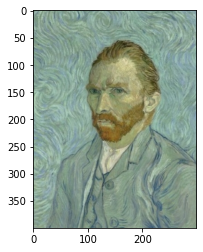

In [6]:
style_image = plt.imread("images/style.jpeg")
print(style_image.shape)
imshow(style_image)

In [7]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    print(A.shape)
    GA = gram_matrix(A)
    print(GA.shape)
    print("GA = " + str(GA.eval()))

(3, 2)
(3, 3)
GA = [[ 15.615461  12.248833 -29.87157 ]
 [ 12.248833  10.877857 -19.879116]
 [-29.87157  -19.879116  67.08007 ]]


###  Style cost


$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  


In [9]:
def compute_layer_style_cost(a_S, a_G):

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(a_S, shape = [n_H * n_W, n_C])
    a_G = tf.reshape(a_G, shape = [n_H * n_W, n_C])
    print(a_S.shape)
    print(a_G.shape)
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))
    print(GS.shape)
    print(GG.shape)

    J_style_layer = (tf.reduce_sum(tf.square(GS - GG)))/(4 * n_C**2 * (n_H * n_W)**2)
    
    
    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    print(a_S.shape)
    print(a_G.shape)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
#     print(J_style_layer.shape)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

(1, 4, 4, 3)
(1, 4, 4, 3)
(16, 3)
(16, 3)
(3, 3)
(3, 3)
J_style_layer = 2.2849257


In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [12]:
def compute_style_cost(model, STYLE_LAYERS):
   
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]

        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

### 3.3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$



In [13]:
def total_cost(J_content, J_style, alpha = 10000, beta = 20000):
    J = alpha * J_content + beta * J_style
    return J

In [14]:
tf.reset_default_graph()  # remove all node in graph and reset it

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 26616.481744542973


In [15]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

# sess = tf.InteractiveSession()
# a = tf.constant(5.0)
# b = tf.constant(6.0)
# c = a * b
# # We can just use 'c.eval()' without passing 'sess'
# print(c.eval())
# sess.close()
# The only difference between Session and an InteractiveSession is that InteractiveSession makes itself the default session so that you can call run() or eval() without explicitly calling the session.
# 
# This can be helpful if you experiment with TF in python shell or in Jupyter notebooks, because it avoids having to pass an explicit Session object to run operations.

In [16]:
content_image = plt.imread("images/c_i.jpeg")
print(content_image.shape)
content_image = reshape_and_normalize_image(content_image)   # doing a/c to vgg requirement
print(content_image.shape)

(400, 300, 3)
(1, 400, 300, 3)
(1, 400, 300, 3)


In [17]:
style_image = plt.imread("images/style.jpeg")
print(style_image.shape)
style_image = reshape_and_normalize_image(style_image)
print(style_image.shape)

(400, 300, 3)
(1, 400, 300, 3)
(1, 400, 300, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


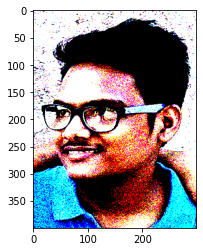

In [18]:
# print(content_image.shape)
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [19]:
# VGG19
# So in simple language VGG is a deep CNN used to classify images. The layers in VGG19 model are as follows:
# input
# Conv3x3 (64)
# Conv3x3 (64)
# MaxPool
# Conv3x3 (128)
# Conv3x3 (128)
# MaxPool
# Conv3x3 (256)
# Conv3x3 (256)
# Conv3x3 (256)
# Conv3x3 (256)
# MaxPool
# Conv3x3 (512)
# Conv3x3 (512)
# Conv3x3 (512)
# Conv3x3 (512)
# MaxPool
# Conv3x3 (512)
# Conv3x3 (512)
# Conv3x3 (512)
# Conv3x3 (512)
# MaxPool
# Fully Connected (4096)
# Fully Connected (4096)
# Fully Connected (1000)
# SoftMax
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")


pretrained-model/imagenet-vgg-verydeep-19.mat
dict_keys(['__header__', '__version__', '__globals__', 'layers', 'meta'])
(1, 43)
<class 'dict'>
<class 'numpy.ndarray'>
[[array([[[[ 0.39416704, -0.08419707, -0.03631314, ..., -0.10720515,
          -0.03804016,  0.04690642],
         [ 0.46418372,  0.03355668,  0.10245045, ..., -0.06945956,
          -0.04020201,  0.04048637],
         [ 0.34119523,  0.09563112,  0.0177449 , ..., -0.11436455,
          -0.05099866, -0.00299793]],

        [[ 0.37740308, -0.07876257, -0.04775979, ..., -0.11827433,
          -0.19008617, -0.01889699],
         [ 0.41810837,  0.05260524,  0.09755926, ..., -0.09385028,
          -0.20492788, -0.0573062 ],
         [ 0.33999205,  0.13363543,  0.02129423, ..., -0.13025227,
          -0.16508926, -0.06969624]],

        [[-0.04594866, -0.11583115, -0.14462094, ..., -0.12290562,
          -0.35782176, -0.27979308],
         [-0.04806903, -0.00658076, -0.02234544, ..., -0.0878844 ,
          -0.3915486 , -0.346327

(3, 3, 256, 512) (512,)
[[array([[[[-6.05492387e-03, -4.95627522e-03,  1.77903252e-03, ...,
          -6.27888972e-03, -8.95445887e-03,  8.66835192e-03],
         [-3.74948140e-03, -4.52641817e-03, -8.90595140e-04, ...,
          -1.58716482e-03, -1.01349372e-02, -1.82842265e-03],
         [ 6.88329688e-04,  1.64529420e-02, -3.94894695e-03, ...,
           9.51744523e-03, -6.90956693e-03,  3.56787513e-03],
         ...,
         [ 2.97582964e-03,  1.88664257e-04, -3.89714446e-03, ...,
           5.88424620e-04,  4.20650374e-03, -7.83154042e-04],
         [ 3.61643871e-03,  5.32191340e-03, -5.85735496e-03, ...,
          -1.27440579e-02,  6.33215485e-03,  2.12557055e-02],
         [-2.02969043e-03, -2.83846795e-03, -3.78161436e-03, ...,
           7.33101415e-03,  5.74376527e-03, -3.83670465e-03]],

        [[ 6.79103099e-03, -8.59935395e-03,  4.20722226e-03, ...,
          -7.45229702e-03, -1.16393473e-02,  4.23566066e-03],
         [-4.08691075e-03, -1.22312026e-03, -3.44491418e-04, .

(3, 3, 512, 512) (512,)
[[array([[[[ 2.89066019e-03,  1.63299795e-02, -1.59145780e-02, ...,
           2.89862193e-02, -1.17501849e-02,  2.16847495e-03],
         [ 7.39247957e-03,  3.84429991e-02,  1.51970319e-03, ...,
           5.18212887e-03,  1.19042955e-02, -2.62843072e-03],
         [-1.38319528e-03, -2.40133563e-03, -1.45964762e-02, ...,
           5.89377945e-03,  7.62553839e-03,  2.36156629e-03],
         ...,
         [-2.56863353e-03,  8.97858385e-03, -6.50021760e-03, ...,
           4.82434733e-03, -6.63608452e-03,  1.15172882e-02],
         [ 1.01007679e-02, -1.46657287e-03,  1.17937643e-02, ...,
          -6.41828217e-03, -4.68117464e-03, -6.34556822e-03],
         [-8.70899111e-03, -5.68474969e-03, -2.75197742e-03, ...,
          -4.03893925e-03, -1.60283782e-02,  3.39478138e-03]],

        [[-4.37433040e-03,  7.73094036e-03, -4.56906164e-05, ...,
           1.12170009e-02, -7.52594834e-03, -6.94604265e-03],
         [ 1.08085871e-02,  4.69049886e-02, -1.14856157e-02, .

(3, 3, 512, 512) (512,)
[[array([[[[ 4.18842398e-03, -1.28599992e-02,  2.23287381e-03, ...,
          -1.10516073e-02, -2.05058493e-02, -5.57976961e-03],
         [-5.03765186e-03, -7.67947990e-04,  2.46402668e-03, ...,
           3.79658653e-03,  4.70313197e-03, -1.12558091e-02],
         [-9.92084574e-03,  2.75714369e-03,  1.07707400e-02, ...,
           1.74441207e-02, -9.59349703e-03,  1.48509704e-02],
         ...,
         [-1.48804486e-02,  9.02904849e-03, -5.56504959e-03, ...,
           3.09626735e-03, -1.23347966e-02, -1.73574872e-03],
         [-4.74564172e-03,  7.11899297e-03, -1.57191139e-02, ...,
           2.91106477e-03, -5.26318606e-03,  6.02464238e-03],
         [ 1.75697054e-03, -5.11527900e-03, -6.05757907e-03, ...,
           1.44334706e-02, -1.14935832e-02,  7.94638600e-03]],

        [[ 3.20805795e-03, -3.46837589e-03,  3.01587698e-03, ...,
          -2.24477686e-02, -1.63569078e-02, -3.70569807e-03],
         [-5.16073313e-03, -3.16332770e-03,  2.09581293e-03, .

(3, 3, 512, 512) (512,)


In [21]:
sess.run(model['input'].assign(content_image))

out = model['conv4_2']

a_C = sess.run(out)
print(a_C)
print('aaaafsadf')
a_G = out
print(a_G)

J_content = compute_content_cost(a_C, a_G)

[[[[ 449.29068     0.          0.       ...    0.        105.24494
     211.63248 ]
   [ 462.99197     0.          0.       ...    0.         30.75216
     368.52014 ]
   [ 346.8037      0.          0.       ...    0.          0.
     250.82027 ]
   ...
   [ 171.84874     0.         50.457203 ...    0.        121.62448
     217.94093 ]
   [ 297.90002     0.        119.93889  ...    0.        307.69214
     274.92316 ]
   [ 318.41336     0.         18.554047 ...    0.        449.42926
     197.69069 ]]

  [[ 522.9326      0.          0.       ...    0.        160.5439
     115.18612 ]
   [ 185.92154     0.          0.       ...    0.          0.
     271.97858 ]
   [   0.          0.          0.       ...    0.          0.
     169.6745  ]
   ...
   [   0.          0.         86.10289  ...  121.31373    10.355985
     473.81702 ]
   [   0.          0.         94.969055 ...  287.73105   186.09605
     416.87027 ]
   [ 203.37279     0.         41.964027 ...   45.63548   464.76413
     230

In [22]:
sess.run(model['input'].assign(style_image))

J_style = compute_style_cost(model, STYLE_LAYERS)

(120000, 64)
(120000, 64)
(64, 64)
(64, 64)
(30000, 128)
(30000, 128)
(128, 128)
(128, 128)
(7500, 256)
(7500, 256)
(256, 256)
(256, 256)
(1900, 512)
(1900, 512)
(512, 512)
(512, 512)
(475, 512)
(475, 512)
(512, 512)
(512, 512)


In [23]:
J = total_cost(J_content, J_style, alpha = 20, beta = 60)

In [24]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [29]:
def model_nn(sess, input_image, num_iterations = 200):
    
    sess.run(tf.global_variables_initializer())
    

# The tf.global_variables_initializer just initializes all variables that tf.global_variables() would list. This actually makes much sense in a distributed environment where the graph might be located in different computing nodes in a cluster.
#In such a case, tf.global_variables_initializer() which is just an alias for tf.variables_initializer(tf.global_variables()) would initialize all the variables in all the computing nodes, where the graph is placed.
    
    sess.run(model["input"].assign(input_image))
    
    for i in range(num_iterations):
        sess.run(train_step)
        generated_image = sess.run(model['input'])
    
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            save_image("output/" + str(i) + ".png", generated_image)
    
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [30]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 559404350.0
content cost = 9701.468
style cost = 9320172.0
Iteration 20 :
total cost = 50394936.0
content cost = 14037.211
style cost = 835236.56
Iteration 40 :
total cost = 18914542.0
content cost = 14579.087
style cost = 310382.66
Iteration 60 :
total cost = 11147985.0
content cost = 14759.023
style cost = 180880.08
Iteration 80 :
total cost = 8134400.0
content cost = 14878.219
style cost = 130613.92
Iteration 100 :
total cost = 6519747.5
content cost = 14973.285
style cost = 103671.37
Iteration 120 :
total cost = 5484510.0
content cost = 15055.815
style cost = 86389.89
Iteration 140 :
total cost = 4751988.0
content cost = 15134.214
style cost = 74155.055
Iteration 160 :
total cost = 4202956.0
content cost = 15207.725
style cost = 64980.02
Iteration 180 :
total cost = 3774411.0
content cost = 15273.819
style cost = 57815.58


array([[[[-1.0463999e+01,  2.7782858e+01,  9.2533417e+01],
         [ 2.7503029e+01,  3.7564915e+01,  3.4460995e+01],
         [ 2.4275459e+01,  7.5163414e+01,  4.4213417e+01],
         ...,
         [ 9.6791630e+00,  5.8840309e+01,  4.4193855e+01],
         [-1.0169244e+00,  5.2225315e+01,  3.9004799e+01],
         [ 2.3816908e+01,  3.7168488e+01,  4.7179371e+01]],

        [[ 6.5949135e+00,  5.0403912e+01,  7.1564369e+01],
         [ 2.9413885e+01,  5.9543457e+01,  3.9756729e+01],
         [ 1.8390577e+01,  4.3452080e+01,  3.6812073e+01],
         ...,
         [-1.8671312e+01,  3.0630695e+01,  2.7288969e+01],
         [ 2.0624823e+01,  3.5119045e+01,  2.6065573e+01],
         [ 2.6381277e+01,  4.1886753e+01,  4.6650867e+01]],

        [[ 1.3378545e+00,  3.9188412e+01,  5.3645721e+01],
         [ 7.0485115e+00,  2.8956877e+01,  3.6702629e+01],
         [ 2.7191454e+01,  3.1198555e+01,  7.1483566e+01],
         ...,
         [-7.6421839e-01,  3.5169201e+01,  5.2757420e+01],
         [

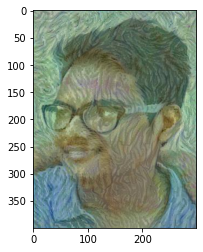

FileNotFoundError: [Errno 2] No such file or directory: 'images/c_i.jpg'

In [31]:
imshow(plt.imread('output/generated_image.jpg'))
plt.show()
imshow(plt.imread('images/c_i.jpg'))
plt.show()
imshow(plt.imread('images/style.jpg'))